# `CLOUD.jl` - 1D linear advection-diffusion example

In [30]:
using CLOUD, OrdinaryDiffEq, Plots, Plots.PlotMeasures

## Define the physical problem

In [31]:
a = 1.0  # wave speed
b = 5.0e-2 # diffusion coefficient
L = 1.0  # domain length
T = 1.0  # end time for one period
CFL = 0.1

initial_data = InitialDataSine(1.0,2π)
conservation_law = LinearAdvectionDiffusionEquation(a,b)
exact_solution = ExactSolution(conservation_law,initial_data);

## Set discretization parameters

In [32]:
M = 4
p = 4
form = WeakConservationForm()
ode_algorithm = CarpenterKennedy2N54();

## Set up a `NodalTensor` scheme of degree `p` with `M` elements

In [33]:
reference_approximation = ReferenceApproximation(
    NodalTensor(p), Line())

mesh = uniform_periodic_mesh(
    reference_approximation.reference_element, (0.0,L), M)

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation)

results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T),
     "results/advection_diffusion_1d/", overwrite=true, clear=true);

## Run the solver and print timer outputs

In [34]:
ode_problem = semidiscretize(conservation_law,
    spatial_discretization,
    initial_data, 
    form,
    (0.0, T))

h = L / (reference_approximation.N_p * spatial_discretization.N_e)
dt = CFL * h / a

CLOUD_reset_timer!()
sol = solve(ode_problem, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false, callback=save_callback(results_path, (0.0,T),  
        floor(Int, T/(dt*50))))
CLOUD_print_timer()

 ────────────────────────────────────────────────────────────────────────────────
            Thread 1                    Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            299ms /  87.6%           70.5MiB /  88.6%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 local residual         4.28k    202ms   77.0%  47.2μs   33.4MiB   53.6%  8.01KiB
   eval flux            4.28k    135ms   51.7%  31.6μs   1.53MiB    2.5%     376B
   gather ext state     4.28k   14.7ms    5.6%  3.44μs   5.74MiB    9.2%  1.38KiB
   apply operators      4.28k   12.2ms    4.6%  2.85μs   5.61MiB    9.0%  1.34KiB
     volume terms       4.28k   1.64ms    0.6%   383ns    601KiB    0.9%     144B
     facet terms        4.28k   1.04ms    0.4%   244ns    334KiB    0.5%    80.0B
     mul test f

## Calculate the integral L<sup>2</sup> error norm

In [35]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
println("L2 error:")
println(analyze(error_analysis, last(sol.u), exact_solution, T)...)

L2 error:
3.118118012190113e-5


## Analyze conservation and energy dissipation

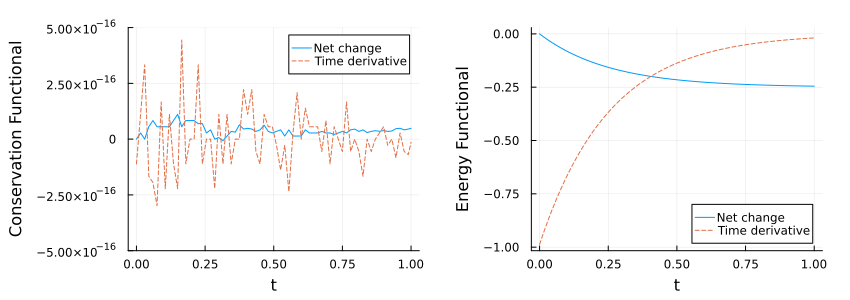

In [36]:
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
p1 = plot(analyze(conservation_analysis, load_time_steps(results_path)), 
    ylabel="Conservation Functional", ylims=[-5e-16, 5e-16])
p2 = plot(analyze(energy_analysis, load_time_steps(results_path)), 
    ylabel="Energy Functional", legend=:bottomright);
plot(p1,p2, size=(850,300),margin=5mm)

## Plot the exact and numerical solutions

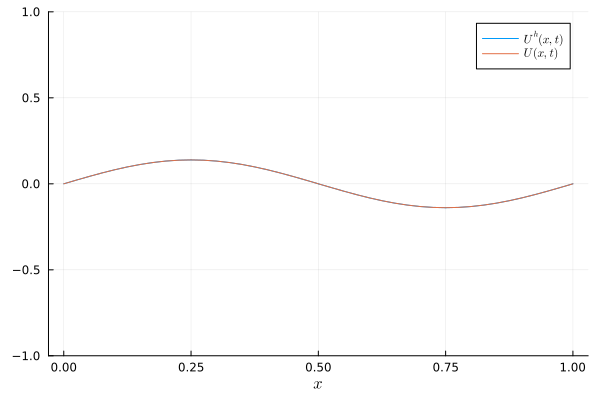

In [37]:
plot(spatial_discretization, last(sol.u), 
    exact_solution=exact_solution, time=T, ylims=[-1.0,1.0])

## Animate the numerical solution

┌ Info: Saved animation to /Users/tristanmontoya/Research/CLOUD.jl/examples/advection_diffusion_solution.gif
└ @ Plots /Users/tristanmontoya/.julia/packages/Plots/gzYVM/src/animation.jl:149


Plots.AnimatedGif("/Users/tristanmontoya/Research/CLOUD.jl/examples/advection_diffusion_solution.gif")
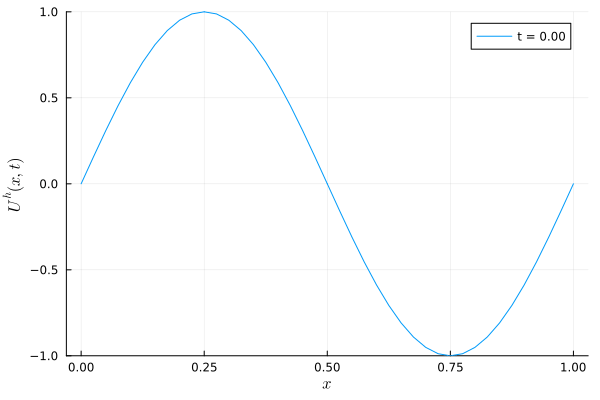

In [38]:
using Printf
anim = @animate for i ∈ eachindex(sol.u)
    plot(spatial_discretization, sol.u[i], 
        ylims=[-1.0,1.0], ylabel="\$U^h(x,t)\$",
        label=string("t = ", @sprintf "%.2f" sol.t[i]))
end
gif(anim, "advection_diffusion_solution.gif", fps = 10)